# EDA 3: Looking at categorical entropy

In [1]:
from itertools import product
from collections import defaultdict, Counter
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

Shannon's informational entropy:

$E = -\sum P_i \cdot log_2(P_i)$

Consider the probability as the ratio of POIs in a region with a given category

In [2]:
from Models.utils import readTrainingData, readPoiCoos

def readCategoryData(categoryFile):
    print('Reading Categories data...')
    categoryData = open(categoryFile, 'r').readlines()
    poiToCategories = defaultdict(list)
    categoryToPois = defaultdict(list)
    for dataInstance in categoryData:
        lid, cid = dataInstance.strip().split()
        lid, cid = int(lid), int(cid)
        poiToCategories[lid].append(cid)
        categoryToPois[cid].append(lid)
    return poiToCategories, categoryToPois

poi_coos = readPoiCoos('../Data/Yelp/poiCoos.txt')
training_matrix, user_checkins, poi_checkins = readTrainingData('../Data/Yelp/train.txt', 7135, 16621, True)
ptc_map, ctp_map = readCategoryData('../Data/Yelp/poiCategories.txt')

Reading PoI coordinates...
Reading training data...
Setting threshold to median repeating POI ratio of 0.7
Setting threshold to 80th prc. of POI visits of 66.0
Reading Categories data...


In [17]:
poi_checkins['log_checkins'] = np.log(poi_checkins['checkins'])
poi_checkins.head()

,checkins,short_head,log_checkins
poi_id,,,
196,1596,True,7.375256
3170,1297,True,7.167809
1515,1277,True,7.152269
1092,1085,True,6.989335
1582,1085,True,6.989335


In [18]:
poi_checkins.tail()

,checkins,short_head,log_checkins
poi_id,,,
9341,1,False,0.0
15444,1,False,0.0
16090,1,False,0.0
780,1,False,0.0
14766,1,False,0.0


In [14]:
next(poi_checkins.iterrows())

(196,
 checkins      1596
 short_head    True
 Name: 196, dtype: object)

In [3]:
gpoi_coos = readPoiCoos('../Data/Gowalla/poiCoos.txt')

Reading PoI coordinates...


In [12]:
np.quantile([1,2,3,8,5,7,6,4,9,10], 0.8)

8.2

In [4]:
poi_geomap = [x for k, x in gpoi_coos.items()]
poi_geomap_sample = pd.DataFrame([poi_geomap[i] for i in np.random.randint(0, len(poi_geomap), size=5000)], columns=['lat', 'long'])
df_poi_coos = pd.DataFrame(poi_geomap, columns=['lat', 'long'])

<Axes: xlabel='lat', ylabel='long'>

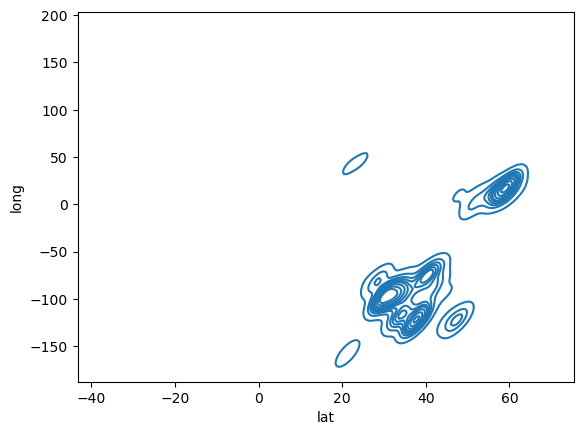

In [5]:
sns.kdeplot(data=df_poi_coos, x='lat', y='long')

In [6]:
allCoos = np.array(poi_geomap)
N = len(poi_geomap)
allCoos.shape

(31803, 2)

In [7]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=8)
poiClusters = clustering.fit_predict(allCoos)

/home/franciszacdlc/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


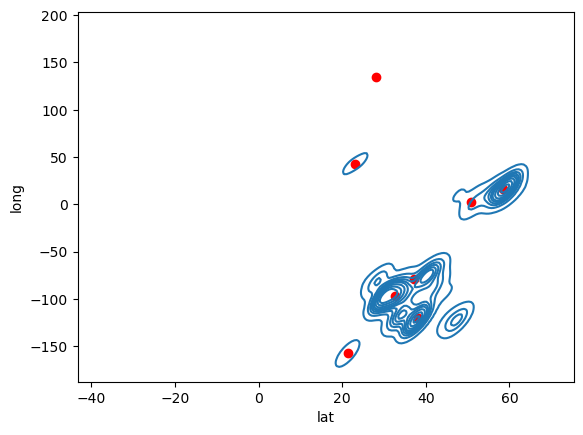

In [8]:
centroids = clustering.cluster_centers_
ax = sns.kdeplot(data=df_poi_coos, x='lat', y='long')
ax.scatter(centroids[:, 0], centroids[:, 1], color='red')

In [9]:
clusterCoos = np.array([centroids[i] for i in poiClusters])
clusterCoos.shape

(31803, 2)

In [10]:
clusterCoos

array([[ 32.61897017, -97.32435607],
       [ 32.61897017, -97.32435607],
       [ 32.61897017, -97.32435607],
       ...,
       [ 58.55367538,  15.8439452 ],
       [ 58.55367538,  15.8439452 ],
       [ 58.55367538,  15.8439452 ]])

## Attempted Methods

* Adaptive KDE for the bandwidth
    * Try and use an AKDE assuming a theoretical user that visits each place once
    * Bandwidth values where absurdly high for some
* Using cluster centroids as means for the AKDE
    * Same issue
* Use bandwidths computed for each cluster
    * Current approach

In [10]:
_bandwidths = []

for i in range(8): # per cluster
    poiClusterCoos = allCoos[poiClusters == i]
    centroidCoos = centroids[i]
    meanCooSqDiff = np.sum((poiClusterCoos - centroidCoos[np.newaxis, :])**2, axis=0) / poiClusterCoos.shape[0]
    Hx, Hy = 1.06 / (poiClusterCoos.shape[0]**0.2) * np.sqrt(meanCooSqDiff)
    _bandwidths.append((Hx, Hy))

bandwidths = np.array(_bandwidths)

In [11]:
bandwidths

array([[0.02212745, 0.02709466],
       [0.00610265, 0.01088361],
       [0.00259885, 0.00702722],
       [0.01230473, 0.01439051],
       [0.00884579, 0.0188884 ],
       [0.01932367, 0.01493846],
       [0.00557389, 0.01162135],
       [0.00318676, 0.00531902]])

In [12]:
def pois_within_std(poiCoo, allCoos, stdCoos, n=2):
    x_std, y_std = stdCoos
    x_i, y_i = poiCoo
    x_min, y_min = x_i - x_std*n, y_i - y_std*n
    x_max, y_max = x_i + x_std*n, y_i + y_std*n
    res = {}
    for ndx, (x, y) in enumerate(allCoos):
        if (x_min <= x <= x_max) and (y_min <= y <= y_max):
            res[ndx] = (x, y)
    return res

In [13]:
poiId = 1
_test = pois_within_std(allCoos[poiId], allCoos, bandwidths[poiClusters[poiId]], n=0.5)
print(len(_test))
_test

5


{1: (40.4081422, -80.0851737),
 13250: (40.4080431671, -80.0873225927),
 13260: (40.4098243713, -80.0853347778),
 14747: (40.407761, -80.086108),
 16553: (40.409746, -80.083623)}

## Computing categorical entropy

In [14]:
def categorical_entropy(poiId, n=0.5):
    # 1. get POIs of interest
    poiCoo = allCoos[poiId]
    neighborhood = pois_within_std(poiCoo, allCoos, bandwidths[poiClusters[poiId]], n)
    # print(f"Neighborhood: {str(neighborhood)}")

    # 2. get categories
    catCounts = Counter([c for p in neighborhood.keys() for c in ptc_map[p]])
    n = len(neighborhood)
    entropy = -1 * np.sum([(count / n) * np.log2(count / n) for _, count in catCounts.items()])
    return entropy

In [15]:
categorical_entropy(1)

2.7863137138648346

In [16]:
poiCatEntropies = np.zeros(len(allCoos))

for i in tqdm(range(len(allCoos))):
    poiCatEntropies[i] = categorical_entropy(i)

100%|█████████████████████████████████████████████████████████████████████████████| 16621/16621 [05:41<00:00, 48.68it/s]


## Correlating popularity with entropy

In [17]:
poi_checkins.head()

,checkins,short_head
poi_id,,
196,1596,True
3170,1297,True
1515,1277,True
1092,1085,True
1582,1085,True


In [18]:
poi_checkins['categorical_entropy'] = pd.Series(poiCatEntropies)

In [19]:
poi_checkins.head()

,checkins,short_head,categorical_entropy
poi_id,,,
196,1596,True,12.406137
3170,1297,True,7.870343
1515,1277,True,9.157419
1092,1085,True,12.935568
1582,1085,True,13.586057


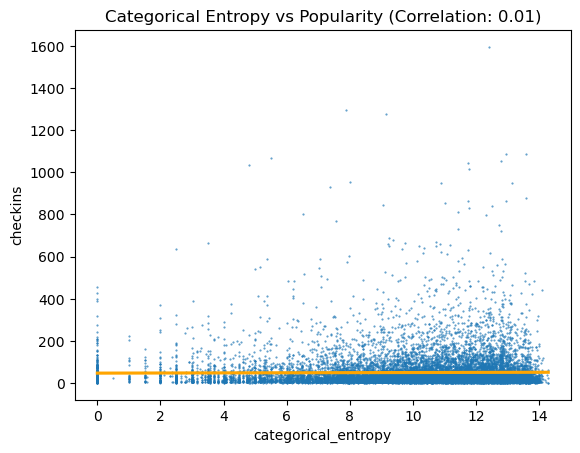

In [20]:
sns.regplot(data=poi_checkins, x='categorical_entropy', y='checkins', marker='.', scatter_kws={'s': 1}, line_kws={'color': 'orange'})
# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=poi_checkins['categorical_entropy'], y=poi_checkins['checkins'])
# annotate the pearson correlation coefficient text to 2 decimal places
plt.title(f'Categorical Entropy vs Popularity (Correlation: {r:.2f})')

plt.show()

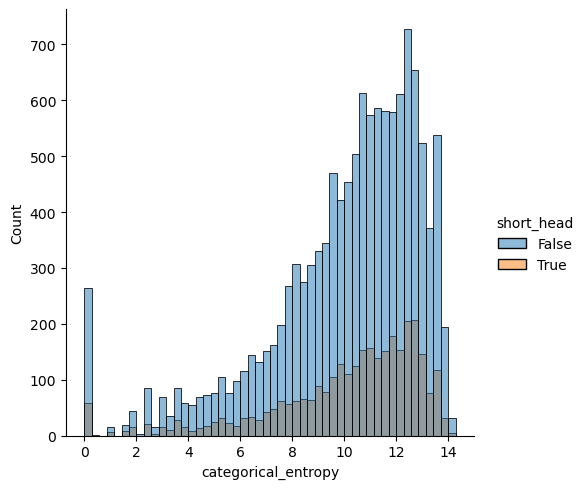

In [21]:
sns.displot(data=poi_checkins, x='categorical_entropy', hue='short_head')

No correlation...

## Item Fairness between high-entropy and low-entropy areas

In [22]:
poi_checkins.categorical_entropy.quantile([0.5, 0.75, 0.8, 0.9])

0.50    10.757928
0.75    12.260256
0.80    12.499700
0.90    13.064463
Name: categorical_entropy, dtype: float64

In [23]:
# Use the median
poi_checkins['high_cat_entropy'] = poi_checkins['categorical_entropy'] >= poi_checkins.categorical_entropy.median()

In [24]:
def load_rec_list(model_name, dataset, provider_factor = 0):
    """
    Per-line format:
    <uid>\t[<lid>,]*
    """
    dataset_sizes = {
        'Yelp': 7135,
        'Gowalla': 5628
    }
    fairness = 'None'
    if provider_factor != 0:
        fairness = 'Provider' + str(provider_factor)
    filename = f"../Outputs/Rec_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.txt"

    recListsFile = open(filename, 'r').readlines()
    recLists = {}
    for dataInstance in recListsFile:
        ndx, uid, lids = dataInstance.strip().split('\t')
        uid = int(uid)
        lids = [int(l) for l in lids.split(',')]
        recLists[uid] = lids
    return recLists

In [25]:
def compute_item_exposure_per_entropy_class(rec_lists: dict, poi_checkins: pd.DataFrame = poi_checkins, ctp: dict = ctp_map):
    """
    Given a dict of rec lists and a dataframe of POI checkins (including the entropy class distinctions), compute the average item exposure.
    """
    user_count = len(rec_lists)
    item_exposure = {c: 0 for c in range(len(poi_checkins))}
    for uid, lids in rec_lists.items():
        for lid in lids:
            if lid in item_exposure:
                item_exposure[lid] += 1

    item_exposure = pd.DataFrame(item_exposure.items(), columns=['poi_id', 'exposure']).set_index('poi_id')
    item_exposure = item_exposure.join(poi_checkins[['categorical_entropy', 'high_cat_entropy']], how='left')
    
    res = item_exposure.groupby('high_cat_entropy')[['exposure']].mean().to_dict()['exposure']
    res = {'high_entropy': res[True], 'low_entropy': res[False]}

    return res, item_exposure

In [26]:
_rec_lists = load_rec_list('USG', 'Yelp')
_, df_usgbase = compute_item_exposure_per_entropy_class(_rec_lists)
df_usgbase['categorical_entropy'] = df_usgbase['categorical_entropy'].fillna(0)
df_usgbase['high_cat_entropy'] = df_usgbase['high_cat_entropy'].fillna(False)
df_usgbase.head()

,exposure,categorical_entropy,high_cat_entropy
poi_id,,,
0,2,-0.000000,False
1,0,2.786314,False
2,0,9.920734,False
3,14,6.201504,False
4,0,9.568026,False


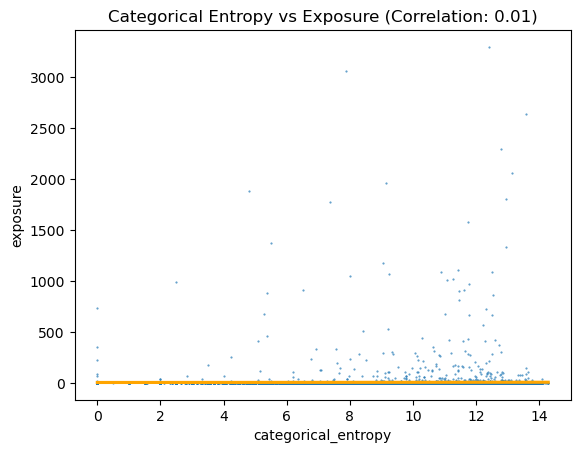

In [27]:
sns.regplot(data=df_usgbase, x='categorical_entropy', y='exposure', marker='.', scatter_kws={'s': 1}, line_kws={'color': 'orange'})
# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=df_usgbase['categorical_entropy'], y=df_usgbase['exposure'])
# annotate the pearson correlation coefficient text to 2 decimal places
plt.title(f'Categorical Entropy vs Exposure (Correlation: {r:.2f})')

plt.show()

In [28]:
_results = []

for alpha in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for model_name in ['USG', 'GeoSoCa', 'LORE']:
        rec_lists = load_rec_list(model_name, 'Yelp', alpha)
        result, _ = compute_item_exposure_per_entropy_class(rec_lists)
        _results.append((
            model_name,
            alpha,
            result['high_entropy'],
            result['low_entropy']
        ))

df_entropy_exposures = pd.DataFrame(_results, columns=['model_name', 'provider_coef', 'high_entropy_exposure', 'low_entropy_exposure'])

In [29]:
df_entropy_exposures.head()

,model_name,provider_coef,high_entropy_exposure,low_entropy_exposure
0,USG,0.0,5.434328,4.198954
1,GeoSoCa,0.0,5.039484,4.462168
2,LORE,0.0,5.040434,4.553931
3,USG,0.1,5.426187,4.206869
4,GeoSoCa,0.1,4.534464,4.075798


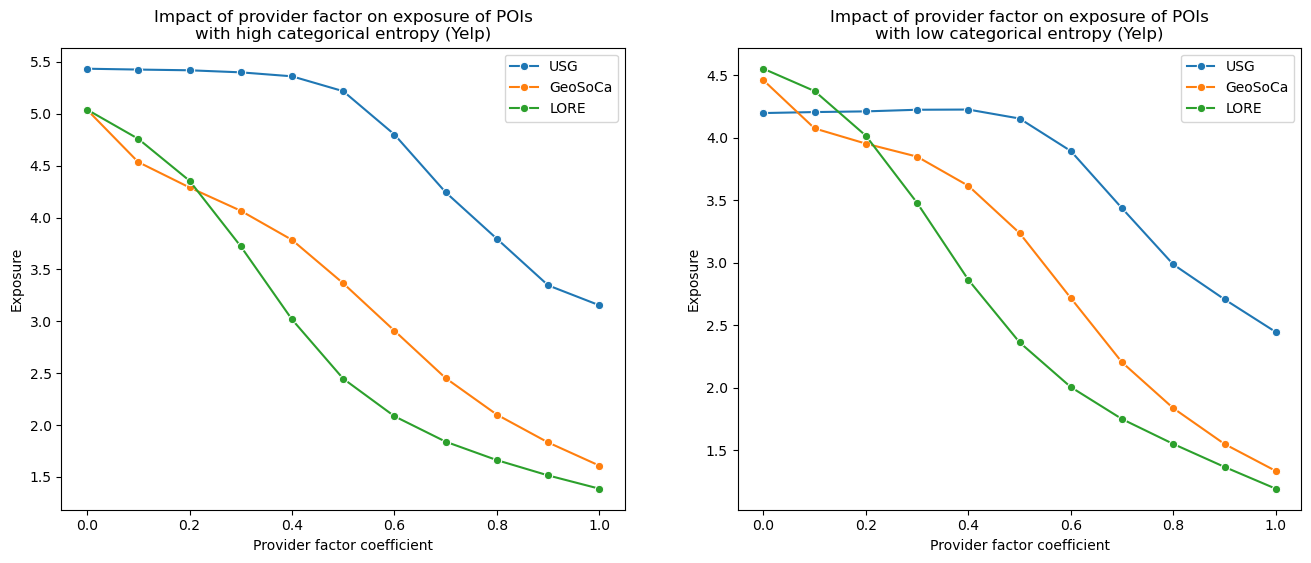

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(data=df_entropy_exposures, x='provider_coef', y='high_entropy_exposure', hue='model_name', marker='o', ax=axs[0])
sns.lineplot(data=df_entropy_exposures, x='provider_coef', y='low_entropy_exposure', hue='model_name', marker='o', ax=axs[1])
axs[0].legend()
axs[0].set_xlabel('Provider factor coefficient')
axs[0].set_ylabel('Exposure')
axs[0].set_title(f'Impact of provider factor on exposure of POIs\nwith high categorical entropy (Yelp)')
axs[1].legend()
axs[1].set_xlabel('Provider factor coefficient')
axs[1].set_ylabel('Exposure')
axs[1].set_title(f'Impact of provider factor on exposure of POIs\nwith low categorical entropy (Yelp)')

fig.savefig(f"images/{model_name}_exposure_by_entropy_vs_provider_alpha.png", bbox_inches='tight')

...???

## User category homogeneity

In [31]:
user_checkins['categorical_entropy'] = 0.0

In [32]:
for uid in tqdm(user_checkins.index):
    visits = [[p] * int(training_matrix[uid, p]) for p in range(len(training_matrix[uid])) if training_matrix[uid][int(p)] > 0]
    visits = [v for vl in visits for v in vl]

    catCounts = Counter([c for p in visits for c in ptc_map[p]])
    n = len(visits)
    entropy = -1 * np.sum([(count / n) * np.log2(count / n) for _, count in catCounts.items()])
    user_checkins.loc[uid, 'categorical_entropy'] = entropy

100%|██████████████████████████████████████████████████████████████████████████████| 7135/7135 [00:50<00:00, 141.64it/s]


In [33]:
user_checkins.head()

,checkins,unique_checkins,repeat_ratio,repeat_user,categorical_entropy
user_id,,,,,
0,113,27,0.761062,True,9.755310
1,31,8,0.741935,False,5.518426
2,451,104,0.769401,True,9.357350
3,44,11,0.750000,True,6.928277
4,440,107,0.756818,True,11.285633


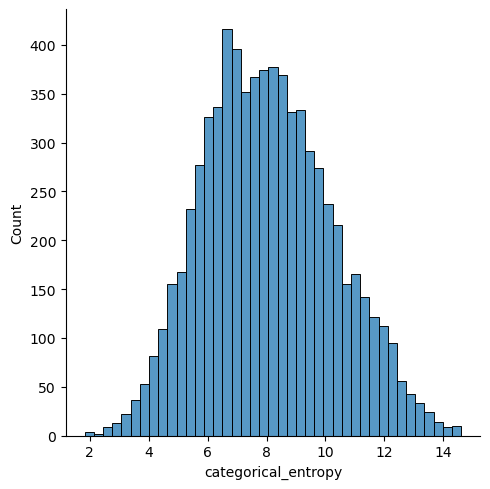

In [34]:
sns.displot(user_checkins['categorical_entropy'])

In [35]:
user_checkins.categorical_entropy.quantile([0.5, 0.75, 0.8, 0.9])

0.50     7.915864
0.75     9.533911
0.80     9.939373
0.90    11.044823
Name: categorical_entropy, dtype: float64

In [36]:
# Use the median
user_checkins['high_cat_entropy'] = user_checkins['categorical_entropy'] >= user_checkins.categorical_entropy.median()

## Computing user precisions

In [37]:
from Models.utils import readTestData

groundTruth = readTestData('../Data/Yelp/test.txt')

Reading test data...


In [38]:
def compute_precision_per_entropy_class(rec_lists):
    """
    Given a dict of rec lists and a dataframe of user checkins (including the entropy class distinctions), compute the average precision.
    """
    user_count = len(rec_lists)
    precisions = []
    for uid, lids in rec_lists.items():
        recommended = set(lids[:10])
        actual = set(groundTruth[uid])
        correct = actual & recommended
        if actual == {}:
            actual = {'a'}
        precisions.append((uid, len(correct) / len(recommended)))

    results = pd.DataFrame(precisions, columns=['user_id', 'precision']).set_index('user_id')
    results = results.join(user_checkins[['categorical_entropy', 'high_cat_entropy']], how='left')

    res = results.groupby('high_cat_entropy')[['precision']].mean().to_dict()['precision']
    res = {'high_entropy': res[True], 'low_entropy': res[False]}

    return res, results

In [39]:
_, _test = compute_precision_per_entropy_class(rec_lists)
_test.head()

,precision,categorical_entropy,high_cat_entropy
user_id,,,
3805,0.0,13.979151,True
3304,0.1,9.353739,True
3324,0.0,8.044745,True
3516,0.0,10.124114,True
6577,0.0,12.014689,True


In [40]:
_results = []

for alpha in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for model_name in ['USG', 'GeoSoCa', 'LORE']:
        rec_lists = load_rec_list(model_name, 'Yelp', alpha)
        result, _ = compute_precision_per_entropy_class(rec_lists)
        _results.append((
            model_name,
            alpha,
            result['high_entropy'],
            result['low_entropy']
        ))

df_entropy_precisions = pd.DataFrame(_results, columns=['model_name', 'provider_coef', 'high_entropy_precision', 'low_entropy_precision'])

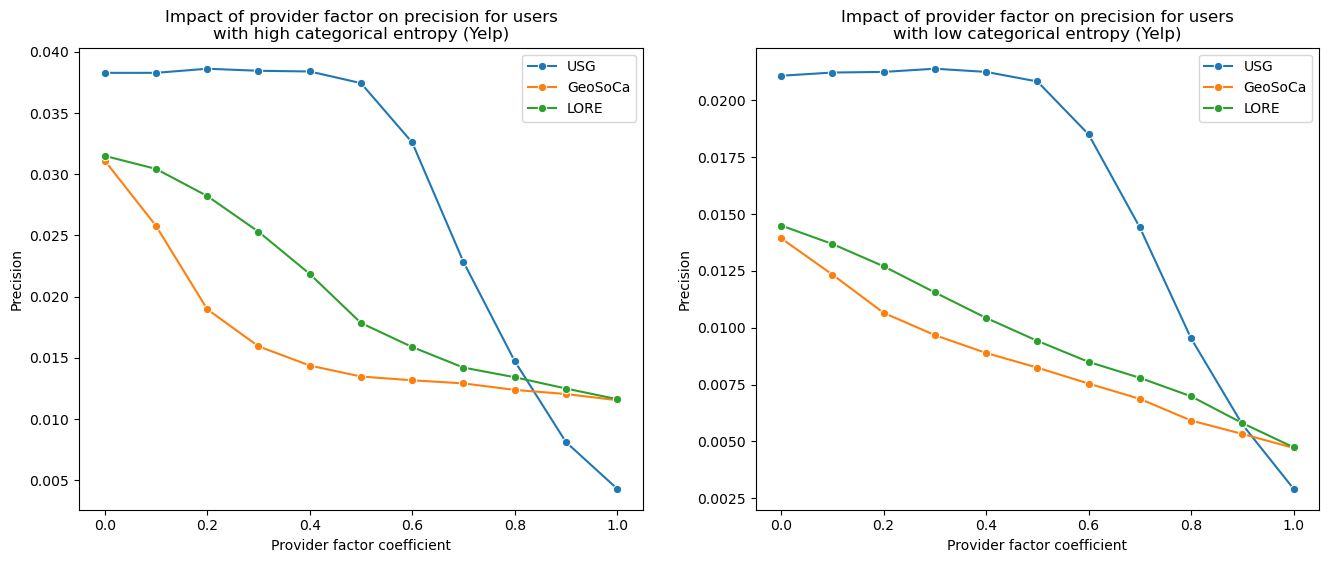

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(data=df_entropy_precisions, x='provider_coef', y='high_entropy_precision', hue='model_name', marker='o', ax=axs[0])
sns.lineplot(data=df_entropy_precisions, x='provider_coef', y='low_entropy_precision', hue='model_name', marker='o', ax=axs[1])
axs[0].legend()
axs[0].set_xlabel('Provider factor coefficient')
axs[0].set_ylabel('Precision')
axs[0].set_title(f'Impact of provider factor on precision for users\nwith high categorical entropy (Yelp)')
axs[1].legend()
axs[1].set_xlabel('Provider factor coefficient')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'Impact of provider factor on precision for users\nwith low categorical entropy (Yelp)')

fig.savefig(f"images/{model_name}_precision_by_entropy_vs_provider_alpha.png", bbox_inches='tight')

Same thing